# Figures

In [1]:
import inverse_folding_free_energies
import os

DEVICE: str = "cpu"  # "cpu", "cuda", "mps"
BATCH_SIZE: int = 64

### Fetch experimental data

In [2]:
import os
if not os.path.exists('data'):
    os.mkdir("data")
%cd data
if not os.path.exists('data_dms'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_dms.tar.gz | tar xz
if not os.path.exists('data_guerois'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_guerois.tar.gz | tar xz
if not os.path.exists('data_protein_g'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_protein_g.tar.gz | tar xz

if not os.path.exists('data_dms/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_dms_mcmc_unfolded.tar.gz | tar xz
if not os.path.exists('data_guerois/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_guerois_mcmc_unfolded.tar.gz | tar xz
if not os.path.exists('data_protein_g/mcmc_samples_unfolded'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/data_protein_g_mcmc_unfolded.tar.gz | tar xz


%cd ..

/Users/wb/projects/inverse_folding_free_energies/git_repo/data
/Users/wb/projects/inverse_folding_free_energies/git_repo


/Users/wb/opt/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Read in experimental data

In [3]:
import glob
import pandas as pd

# Read in data
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
}
pdb_dict = {}
for ddg_key in ddg_data_dict:
    pdb_dict.update({os.path.split(path)[-1].split('_')[0]: path for path in glob.glob(f"data/data_{ddg_key}/pdbs_cleaned/*.pdb")})

md_pdb_dict = {}
# FIXME: Hardcoding residue index offset here. 
md_pdb_index_offsets = {'guerois':{'1A2P':2, '1BF4':1, '1CEY': 1, '1FMK':81, '1HFZ': -1, '1HZ6': -3, '1LMB': 5, '1MJC': 1, '1QHE': 1, '1SHF': 83, '1SHG': 5, '1STN': 5, '1TEN': 801, '2CI2': 18}} 
for ddg_key in ddg_data_dict:
    md_pdb_dict[ddg_key] = {}
    # Reading in at X000ps intervals. Including MD starting point.
    for path in sorted(glob.glob(f"data/data_{ddg_key}/molecular_dynamics_npt/pdbs_cleaned/*[_1]?000ps_clean.pdb")) + glob.glob(f"data/data_{ddg_key}/pdbs_cleaned/*.pdb"):
        pdb_id = os.path.split(path)[-1].split('_')[0].upper()

        if pdb_id not in md_pdb_dict[ddg_key]:
            md_pdb_dict[ddg_key][pdb_id] = []
        md_pdb_dict[ddg_key][pdb_id].append(path)

unfolded_pdb_dict = {}
for ddg_key in ddg_data_dict:
    unfolded_pdb_dict[ddg_key] = {}
    for path in sorted(glob.glob(f"data/data_{ddg_key}/mcmc_samples_unfolded/samples_????_*")):

        # Discard _mt simulations - we'll stick with importance sampling just as in the folded state
        if '_mt' in os.path.split(path)[-1]:
            continue

        pdb_id = os.path.split(path)[-1].split('_')[1].upper()
        variant = os.path.split(path)[-1].split('_')[2]
        if pdb_id not in unfolded_pdb_dict[ddg_key]:
            unfolded_pdb_dict[ddg_key][pdb_id] = {}

        for filename in glob.glob(f"{path}/*.pdb"):
            filename = filename.replace(variant, '{}')
            unfolded_pdb_dict[ddg_key][pdb_id][filename] = True

### Retrieve AA frequencies

In [4]:
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO

if not os.path.exists("UP000005640_9606.fasta"):
    !wget https://sid.erda.dk/share_redirect/eRmsTXG7xt/UP000005640_9606.fasta

human_proteome_aa_dist = inverse_folding_free_energies.get_proteome_reference_aa_dist("UP000005640_9606.fasta")
idp_aa_stats = inverse_folding_free_energies.get_intrinsically_disorded_aa_dist()

### Likelihood evaluation code 

In [5]:
def calculate_single_sample_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                                    pdb_dict=md_pdb_dict, pdb_index_offsets=md_pdb_index_offsets, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods using only a single structural sample for the folded state"""
    results_single_sample = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            chain_id = grp['chainid'].iloc[0]
            structure_filename = pdb_dict[pdb_id]

            dfs.append(likelihood_evaluator(grp, structure_filename, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                            output_file_prefix=output_file_prefixer(ddg_data_key, structure_filename)))

            dfs[-1].insert(0, 'filename', structure_filename)
            
        results_single_sample[ddg_data_key] = pd.concat(dfs)

    return results_single_sample


def calculate_multi_sample_results(protein_experiment_dict, likelihood_evaluator, output_file_prefixer, 
                                   pdb_dict=md_pdb_dict, pdb_index_offsets=md_pdb_index_offsets, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods using an ensemble of structural sample for the folded state"""

    results_multi_sample = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in pdb_dict[ddg_data_key]:
                print(f"WARNING: no simulation available for {pdb_id}. Skipping.")
                continue

            for structure_filename in pdb_dict[ddg_data_key][pdb_id]:
                chain_id = grp['chainid'].iloc[0]
                index_offset = 0
                if ddg_data_key in pdb_index_offsets and pdb_id in pdb_index_offsets[ddg_data_key]:
                    index_offset = pdb_index_offsets[ddg_data_key][pdb_id]

                dfs.append(likelihood_evaluator(grp, structure_filename, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                                output_file_prefix=output_file_prefixer(ddg_data_key, structure_filename)))
                dfs[-1].insert(0, 'filename', structure_filename)

            results_multi_sample[ddg_data_key] = pd.concat(dfs)

    return results_multi_sample


def calculate_unfolded_results(protein_experiment_dict, likelihood_evaluator, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods for the unfolded state. The PDB files are specified as a pattern where variant are inserted automatically"""

    # Unfolded results
    results_unfolded = {}
    for ddg_data_key, df in protein_experiment_dict.items():

        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in unfolded_pdb_dict[ddg_data_key]:
                print(f"WARNING: no unfolded simulation data available for {pdb_id}. Skipping.")
                continue

            for pattern in unfolded_pdb_dict[ddg_data_key][pdb_id]:
                chain_id = 'A'

                # Mutant calculations
                df_mt = likelihood_evaluator(grp, pattern, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                             output_file_prefix=f'{ddg_data_key}_unfolded_{pdb_id}_mt_')
                df_mt.insert(0, 'mt/wt', 'MT')            

                # Wildtype calculations
                df_wt = likelihood_evaluator(grp, pattern, pdb_id, use_cache=use_cache, batch_size=batch_size,
                                             output_file_prefix=f'{ddg_data_key}_unfolded_{pdb_id}_')
                df_wt.insert(0, 'mt/wt', 'WT')

                df = pd.concat([df_mt, df_wt])            
                df.insert(0, 'filename', os.path.split(pattern)[-1])

                dfs.append(df)
                
            results_unfolded[ddg_data_key] = pd.concat(dfs)

    return results_unfolded


def calculate_unfolded_single_sample_results(protein_experiment_dict, likelihood_evaluator, use_cache=False, batch_size=BATCH_SIZE):
    """Calculate inverse-folding likelihoods for the unfolded state by evaluating on the native structure, on a small fragment around the site of interest"""

    # Unfolded results - single sample
    results_unfolded_single_sample = {}

    for ddg_data_key, df in protein_experiment_dict.items():
 
        dfs = []
        for pdb_id, grp in df.groupby('pdbid'):

            if pdb_id not in unfolded_pdb_dict[ddg_data_key]:
                print(f"WARNING: no unfolded simulation data available for {pdb_id}. Skipping.")
                continue

            chain_id = grp['chainid'].iloc[0]
            structure_filename = pdb_dict[pdb_id]
            
            # Mutant calculations
            evaluate_pdb_seq = False
            df_mt = likelihood_evaluator(grp, structure_filename, pdb_id, chain_id, 
                                         output_file_prefix=f'{ddg_data_key}_unfolded_mt_', 
                                         evaluate_pdb_seq=evaluate_pdb_seq,
                                         use_cache=use_cache, batch_size=batch_size, 
                                         evaluate_fragment=True)
            df_mt.insert(0, 'mt/wt', 'MT')            

            # Wildtype calculations
            evaluate_pdb_seq = True
            df_wt = likelihood_evaluator(grp, structure_filename, pdb_id, chain_id, 
                                         output_file_prefix=f'{ddg_data_key}_unfolded_', 
                                         evaluate_pdb_seq=evaluate_pdb_seq,
                                         use_cache=use_cache, batch_size=batch_size, 
                                         evaluate_fragment=True)
            df_wt.insert(0, 'mt/wt', 'WT')

            df = pd.concat([df_mt, df_wt])            
            df.insert(0, 'filename', structure_filename)

            dfs.append(df)
                
        results_unfolded_single_sample[ddg_data_key] = pd.concat(dfs)

    return results_unfolded_single_sample

### Postprocessing code

In [6]:
def postprocess_single(results_single_sample, prediction_label):
    """Postprocess inverse-folding likelihoods - single structure case"""

    df_single = None

    for ddg_data_key in results_single_sample:

        # Process single-sample results
        df = results_single_sample[ddg_data_key]
        ddgs = None
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            # Separate mutant entries from wildtype entries
            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant'])
            wt_ref = grp.loc[grp['variant'].isna(), prediction_label].unique()[0]

            values = values.rename(columns={prediction_label: 'logp_mt'})
            values['logp_wt'] = wt_ref
            values['simulated'] = False

            if df_single is None:
                df_single = values
            else:
                df_single = pd.concat([df_single, values])
    
    return df_single


def postprocess_md(results_md, prediction_label):
    """Postprocess inverse-folding likelihoods - multiple structure case"""

    df_multi = None

    for ddg_data_key in results_md:

        # Process multi-sample results
        df = results_md[ddg_data_key]
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])
            wt_ref = grp.loc[grp['variant'].isna() ]
            wt_ref = wt_ref[~wt_ref.duplicated(['filename'])].set_index(['dataset', 'pdbid', 'variant', 'filename'])

            values = values.rename(columns={prediction_label: 'logp_mt'})

            # Temporary remove variant from index to allow wildtype assignment (which has NaN variant)
            values = values.reset_index('variant')
            values['logp_wt'] = wt_ref.reset_index('variant')[prediction_label]
            values['simulated'] = True
            values = values.reset_index().set_index(['dataset', 'pdbid', 'variant', 'filename'])

            if df_multi is None:
                df_multi = values
            else:
                df_multi = pd.concat([df_multi, values])
    return df_multi

def postprocess_unfolded(results_unfolded, prediction_label):
    """Postprocess inverse-folding likelihoods - unfolded, multi-sample case"""

    df_unfolded = None

    for ddg_data_key in results_unfolded:

        # Process unfolded results
        df = results_unfolded[ddg_data_key]
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])

            wt_ref = values.loc[values['mt/wt']=='WT', prediction_label]
            values = values.loc[values['mt/wt']=='MT', prediction_label].to_frame('logp_mt')
            values['logp_wt'] = wt_ref

            if df_unfolded is None:
                df_unfolded = values
            else:
                df_unfolded = pd.concat([df_unfolded, values])

    return df_unfolded


def postprocess_unfolded_single(results_unfolded_single_sample, prediction_label):
    """Postprocess inverse-folding likelihoods - unfolded, single-sample case"""

    df_unfolded_single = None

    for ddg_data_key in results_unfolded_single_sample:

        # Process single-sample unfolded results
        df = results_unfolded_single_sample[ddg_data_key]
        ddgs = None
        for pdb_id, grp in df.groupby('pdbid'):
            grp.insert(0, 'dataset', ddg_data_key)            

            values = (grp[grp['variant'].notna()]).set_index(['dataset', 'pdbid', 'variant', 'filename'])

            wt_ref = values.loc[values['mt/wt']=='WT', prediction_label]
            values = values.loc[values['mt/wt']=='MT', prediction_label].to_frame('logp_mt')
            values['logp_wt'] = wt_ref

            if df_unfolded_single is None:
                df_unfolded_single = values
            else:
                df_unfolded_single = pd.concat([df_unfolded_single, values])

    return df_unfolded_single

## Figure 1
### Initialize ESM-IF

In [7]:
from inverse_folding_free_energies import *

import esm

# Create model
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model.to(DEVICE)
model = model.eval().requires_grad_(False)

/Users/wb/opt/miniconda3/lib/python3.12/site-packages/esm/pretrained.py:216: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


### Retrieve cached outputs

In [8]:
if not os.path.exists('outputs'):
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_single_sample_dms_guerois_protein_g.tar.gz | tar xz
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_md_dms_guerois_protein_g.tar.gz | tar xz
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_unfolded_dms_guerois_protein_g.tar.gz | tar xz    
    !curl https://sid.erda.dk/share_redirect/eRmsTXG7xt/cached_output_unfolded_single_fragments_dms_guerois_protein_g.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  167k  100  167k    0     0   919k      0 --:--:-- --:--:-- --:--:--  924k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3067k  100 3067k    0     0  9444k      0 --:--:-- --:--:-- --:--:-- 9466k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7031k  100 7031k    0     0  11.6M      0 --:--:-- --:--:-- --:--:-- 11.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  305k  100  305k    0     0  1857k      0 --:--:-- --:--:-- --:--:-- 1850k


### Calculate and process likelihood scores

In [9]:
from functools import partial

# Single sample results
results_single_sample = calculate_single_sample_results(
    ddg_data_dict, 
    partial(inverse_folding_free_energies.esm_calculate_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: f"{ddg_data_key}_",
    pdb_dict=pdb_dict, use_cache=True)

# Multi sample (MD) results
results_md = calculate_multi_sample_results(
    ddg_data_dict, 
    partial(inverse_folding_free_energies.esm_calculate_likelihoods, model, alphabet),
    output_file_prefixer = lambda ddg_data_key, structure_filename: 
        f"{ddg_data_key}_" if not "molecular_dynamics" in structure_filename else f"{ddg_data_key}_md_",
    pdb_dict=md_pdb_dict, use_cache=True)

# Unfolded state: multiple samples
results_unfolded = calculate_unfolded_results(
    ddg_data_dict, 
    partial(inverse_folding_free_energies.esm_calculate_likelihoods, model, alphabet),
    use_cache=True)

# Unfolded state: single sample (fragment of wildtype)
results_unfolded_single_sample = calculate_unfolded_single_sample_results(
    ddg_data_dict, 
    partial(inverse_folding_free_energies.esm_calculate_likelihoods, model, alphabet),
    use_cache=True) 

# Postprocess data
df_single = postprocess_single(results_single_sample, prediction_label="ESM-IF")
df_multi = postprocess_md(results_md, prediction_label="ESM-IF")
df_unfolded = postprocess_unfolded(results_unfolded, prediction_label="ESM-IF")
df_unfolded_single = postprocess_unfolded_single(results_unfolded_single_sample, prediction_label="ESM-IF")

# remove filename from index
df_multi = df_multi.reset_index(3)
df_unfolded = df_unfolded.reset_index(3)
df_unfolded_single = df_unfolded_single.reset_index(3)

### Calculate ddg strategies

In [25]:
import scipy

# Different DDG strategies

ddgs = df_single['ddg'].to_frame('ddg')

# Simple likelihood ratio
# ddgs['ll_ratio'] = -(df_single['logp_mt'] - df_single['logp_wt'])
ddgs['folded:single'] = -(df_single['logp_mt'] - df_single['logp_wt'])

# Compensation with p(a)
variants = pd.Series(df_single.index.get_level_values(2), index=df_single.index)
logp_a_mt = variants.str[-1].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
logp_a_wt = variants.str[0].transform(lambda aa: np.log(human_proteome_aa_dist[aa]))
ddgs['p(a)-compensation'] = (logp_a_wt - logp_a_mt)
ddgs['folded:single, p(a)-compensation'] = ddgs['folded:single'] - ddgs['p(a)-compensation']

# Multi-sample approximation to the expectation
ddgs['folded:multi'] = ((-(df_multi['logp_mt'] - df_multi['logp_wt']))
                            .groupby(df_multi.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs['folded:multi, p(a)-compensation'] = ddgs['folded:multi'] - ddgs['p(a)-compensation']

# Simple likelihood ratio, unfolded (using inverse-folding on fragment of native)
ddgs['unfolded:single'] = -(df_unfolded_single['logp_mt'] - df_unfolded_single['logp_wt'])
ddgs['folded:single | unfolded:single'] = ddgs['folded:single'] - ddgs['unfolded:single']
ddgs['folded:multi | unfolded:single'] = ddgs['folded:multi'] - ddgs['unfolded:single']

# Sampling from the unfolded state (MCMC)
ddgs['unfolded:multi'] = (-(df_unfolded['logp_mt'] - df_unfolded['logp_wt'])
                            .groupby(df_unfolded.index).agg(
                                            lambda g:scipy.special.logsumexp(g) - np.log(len(g))))
ddgs['folded:single | unfolded:multi'] = ddgs['folded:single'] - ddgs['unfolded:multi']
ddgs['folded:multi | unfolded:multi'] = ddgs['folded:multi'] - ddgs['unfolded:multi']

# Unfolded state using IDP stats
logp_a_mt_idp = variants.str[-1].transform(lambda aa: np.log(idp_aa_stats[aa]))
logp_a_wt_idp = variants.str[0].transform(lambda aa: np.log(idp_aa_stats[aa]))
ddgs['folded:single | unfolded:IDP'] = ddgs['folded:single'] - (logp_a_wt_idp - logp_a_mt_idp)
ddgs['folded:multi | unfolded:IDP'] = ddgs['folded:multi'] - (logp_a_wt_idp - logp_a_mt_idp)


### Calculate correlations

In [ ]:
import scipy

def calculate_correlations(ddgs, outer_iteration, inner_iteration, n_bootstrap_resamples=100, flip_sign=False):
    """Calculate Spearman or Pearson correlation coefficients, with bootstrapped errorbars """

    notna_mask = ddgs['folded:single'].notna()

    correlations = []
    for correlation_metric_name, correlation_metric in {'pearson': scipy.stats.pearsonr, 'spearman':scipy.stats.spearmanr}.items():
        for ddg_data_key, ddgs_per_dataset in ddgs.groupby(ddgs.index.get_level_values(0)):

            for outer in outer_iteration:
                for inner in inner_iteration:

                    label = outer+inner
                    label_ref = 'ddg'
                    factor = 1.0 if not flip_sign else -1
                    r = correlation_metric(ddgs_per_dataset.loc[notna_mask, label], 
                                           ddgs_per_dataset.loc[notna_mask, label_ref]*factor).correlation
                    se = scipy.stats.bootstrap((ddgs_per_dataset.loc[notna_mask, label].values, 
                                                ddgs_per_dataset.loc[notna_mask, label_ref].values*factor), 
                                                lambda x,y: correlation_metric(x,y).correlation, 
                                                vectorized=False, paired=True, method='basic', n_resamples=n_bootstrap_resamples).standard_error                       
                    correlations.append({'dataset': f'{ddg_data_key}', 'strategy': label, 'r': r, 'se': se, 'metric': correlation_metric_name})

    correlation_df = pd.DataFrame(correlations).set_index('metric')

    return correlation_df


correlation_df = calculate_correlations(ddgs, 
                                         ['folded:single', 'folded:multi'], 
                                         ['', ', p(a)-compensation', ' | unfolded:multi', ' | unfolded:single', ' | unfolded:IDP'])


In [ ]:
name_mapping = {'dataset': {'protein_g': "Protein G",
                            'dms' : "VAMP-seq",
                            'guerois': "Guerois"},
                'strategy': {
                        'folded:single':       r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \vphantom{\bigg \rangle_{F}}$ \\ \small{\textit{folded:single}}",
                        'folded:multi':       r"$-\ln\left \langle\frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}\right \rangle_{F}$ \\ \small{\textit{folded:multi (MD)}}",
                        'folded:single, p(a)-compensation':      r"$-\ln\frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \vphantom{\bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}\phantom{'})}{p_\theta(\bf{a}')}$ \\[0.15em] \small{\textit{folded:single, $p_\theta(\bf{a})$ correction}}",
                        'folded:multi, p(a)-compensation':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \frac{p_\theta(\bf{a}\phantom{'})}{p_\theta(\bf{a}')}$\\ \small{\textit{folded:multi (MD), $p_\theta(\bf{a})$ correction}}",
                        'folded:single | unfolded:multi':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{\bigg \rangle_{F}} - \ln \left \langle \frac{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})} \right \rangle_{U}$\\[0.15em] \small{\textit{folded:single | unfolded multi (MC)}}",
                        'folded:multi | unfolded:multi':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \left \langle \frac{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})} \right \rangle_{U}$\\[0.1em] \small{\textit{folded:multi (MD), unfolded:multi (MC)}}",
                        'folded:single | unfolded:single':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{\bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}_i | \bf{x}_{\bf{a}_{i-1:i+1}})}{p_\theta(\bf{a}'_i | \bf{x}_{\bf{a}_{i-1:i+1}})} \vphantom{\bigg \rangle_{U}}$\\[0.125em] \small{\textit{folded:single | unfolded:single (inv-fold single-aa)}}",
                        'folded:multi | unfolded:single':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} - \ln \frac{p_\theta(\bf{a}_i | \bf{x}_{\bf{a}_{i-1:i+1}})}{p_\theta(\bf{a}'_i | \bf{x}_{\bf{a}_{i-1:i+1}})} \vphantom{\bigg \rangle_{U}}$\\[0.125em] \small{\textit{folded multi (MD) | unfolded:single (inv-fold single-aa)}}",
                        'folded:single | unfolded:IDP':      r"$-\ln \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})}  \vphantom{ \bigg \rangle_{F}} - \ln \frac{p_\theta(\bf{a}\phantom{'} | U_\text{IDP})}{p_\theta(\bf{a}' | U_\text{IDP})} $\\[0.2em] \small{\textit{folded:single | unfolded:IDP}}",
                        'folded:multi | unfolded:IDP':      r"$-\ln \left \langle \frac{p_\theta(\bf{a}' | \bf{x}_{\bf{a}})}{p_\theta(\bf{a}\phantom{'} | \bf{x}_{\bf{a}})} \right \rangle_{F} \hspace*{-0.5em} - \ln \frac{p_\theta(\bf{a}\phantom{'} | U_\text{IDP})}{p_\theta(\bf{a}' | U_\text{IDP})}$\\[0.1em] \small{\textit{folded:multi (MD), unfolded:IDP}}",
                        }
}
correlation_df_relabeled = correlation_df.replace(to_replace=name_mapping)

### Plot

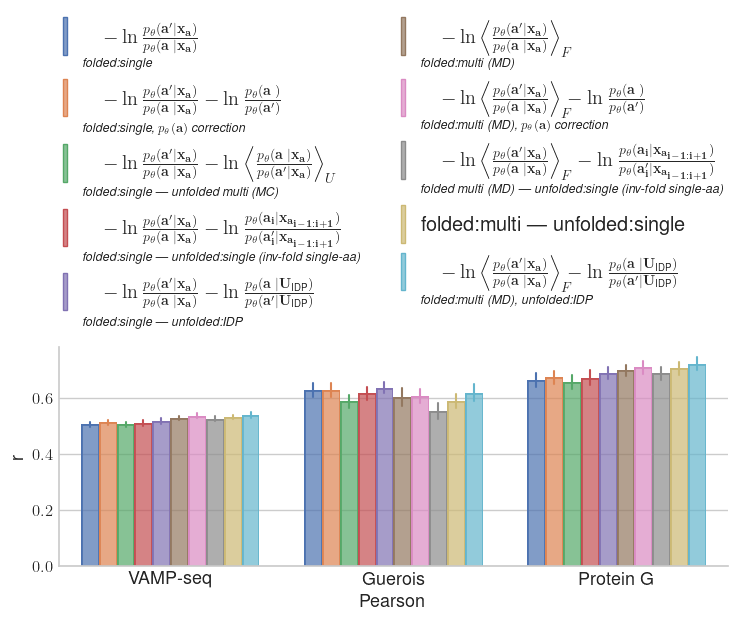

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_figure1(correlation_df, which_coefficients=['pearson', 'spearman']):

    colors = ['#DB444B', '#006BA2', '#3EBCD2', '#379A8B', '#EBB434', '#B4BA39', '#9A607F', '#D1B07C']
    saturation = 0.75

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
    })
    plt.rc('text.latex', preamble=r'\usepackage{helvet}\usepackage{amstext}')

    sns.set(font_scale = 1.2)
    sns.set_palette(sns.color_palette(colors))
    sns.set_style("whitegrid")

    if len(which_coefficients) == 2:
        fig, axs = plt.subplots(ncols=2, figsize=(7.4,6), sharey=True, squeeze=False)
    else:
        fig, axs = plt.subplots(ncols=1, figsize=(7.4,6), sharey=True, squeeze=False)
    axs = axs.ravel()

    correlation_df['r_min'] = correlation_df['r'] - correlation_df['se']
    correlation_df['r_max'] = correlation_df['r'] + correlation_df['se']

    import seaborn.objects as so

    for idx, metric in enumerate(which_coefficients):

        p = (
            so.Plot(data=correlation_df.loc[metric], x="dataset", y="r", ymin='r_min', ymax='r_max', color="strategy")
            .add(so.Bar(), so.Dodge())
            .add(so.Range(), so.Dodge())
            .on(axs[idx])
            .plot()
        )
        sns.despine(ax=axs[idx])
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')
        axs[idx].set_xlabel(f'{metric.capitalize()}', fontsize=13)
        if idx==0:
            axs[0].set_ylabel('r', fontsize=13)
        legend = fig.legends.pop(0)

        if idx==0:
            axs[idx].tick_params(axis='y', which='major', labelbottom = True, bottom=False, top = False, labeltop=False, pad=-2, labelsize=12)
        else:
            axs[idx].tick_params(axis='y', which='major', labelleft=False, labelbottom = False, bottom=False, top = False, labeltop=False, pad=-2, labelsize=12)

        axs[idx].tick_params(axis='x', which='major', labelbottom = True, bottom=False, top = False, labeltop=False, pad=-2, labelsize=13)

        if idx==0:    
            if len(which_coefficients) == 2:
                axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(1.05, 1.0), ncol=2, frameon=False, fontsize='medium', handleheight=2.5, handlelength=0.2)
            else:
                axs[idx].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='lower center',  bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, fontsize='medium', handleheight=2.5, handlelength=0.2)


    plt.subplots_adjust(left=0.075, right=0.98, bottom=0.075, top=0.44, wspace = 0.05)

    del correlation_df['r_min']
    del correlation_df['r_max']

    plt.savefig('figure1_vert.pdf')
    plt.savefig('figure1_vert.svg')

plot_figure1(correlation_df_relabeled, which_coefficients=['pearson'])